# Example 2: Entangling quantum gates for coupled transmon qubits

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

In [1]:
using DrWatson
@quickactivate "GRAPETests"
using QuantumControl

This example illustrates the optimization towards a perfectly entangling
two-qubit gate for a system of two transmon qubits with a shared transmission
line. It goes through three progressively more advanced optimizations:

1. The direct optimization for a $\Op{O} = \sqrt{\text{iSWAP}}$ gate with a
   standard square-modulus functional
2. The optimization towards a perfect entangler using the functional
   developed in Goerz et al., Phys. Rev. A 91, 062307 (2015)
3. The direct maximization of of the gate concurrence

While the first example evaluates the gradient of the optimization functional
analytically, the latter two are examples for the use of automatic
differentiation, or more specifically semi-automatic differentiation, as
developed in Goerz et al., arXiv:2205.15044. The optimization of the gate
concurrence specifically illustrates the optimization of a functional that is
inherently non-analytical.

## Hamiltonian and guess pulses

We will write the Hamiltonian in units of GHz (angular frequency; the factor
2π is implicit) and ns:

In [2]:
const GHz = 2π
const MHz = 0.001GHz
const ns = 1.0
const μs = 1000ns;

The Hamiltonian and parameter are taken from Goerz et. al., Phys. Rev. A 91,
062307 (2015)., cf. Table 1 in that Reference.

In [3]:
⊗ = kron
const 𝕚 = 1im
const N = 6  # levels per transmon

using LinearAlgebra
using SparseArrays

function transmon_hamiltonian(;
    Ωre,
    Ωim,
    N=N,  # levels per transmon
    ω₁=4.380GHz,
    ω₂=4.614GHz,
    ωd=4.498GHz,
    α₁=-210MHz,
    α₂=-215MHz,
    J=-3MHz,
    λ=1.03,
    use_sparse=:auto
)
    𝟙 = SparseMatrixCSC{ComplexF64,Int64}(sparse(I, N, N))
    b̂₁ = spdiagm(1 => complex.(sqrt.(collect(1:N-1)))) ⊗ 𝟙
    b̂₂ = 𝟙 ⊗ spdiagm(1 => complex.(sqrt.(collect(1:N-1))))
    b̂₁⁺ = sparse(b̂₁')
    b̂₂⁺ = sparse(b̂₂')
    n̂₁ = sparse(b̂₁' * b̂₁)
    n̂₂ = sparse(b̂₂' * b̂₂)
    n̂₁² = sparse(n̂₁ * n̂₁)
    n̂₂² = sparse(n̂₂ * n̂₂)
    b̂₁⁺_b̂₂ = sparse(b̂₁' * b̂₂)
    b̂₁_b̂₂⁺ = sparse(b̂₁ * b̂₂')

    ω̃₁ = ω₁ - ωd
    ω̃₂ = ω₂ - ωd

    Ĥ₀ = sparse(
        (ω̃₁ - α₁ / 2) * n̂₁ +
        (α₁ / 2) * n̂₁² +
        (ω̃₂ - α₂ / 2) * n̂₂ +
        (α₂ / 2) * n̂₂² +
        J * (b̂₁⁺_b̂₂ + b̂₁_b̂₂⁺)
    )

    Ĥ₁re = (1 / 2) * (b̂₁ + b̂₁⁺ + λ * b̂₂ + λ * b̂₂⁺)
    Ĥ₁im = (𝕚 / 2) * (b̂₁⁺ - b̂₁ + λ * b̂₂⁺ - λ * b̂₂)

    if ((N < 5) && (use_sparse ≢ true)) || use_sparse ≡ false
        H = hamiltonian(Array(Ĥ₀), (Array(Ĥ₁re), Ωre), (Array(Ĥ₁im), Ωim))
    else
        H = hamiltonian(Ĥ₀, (Ĥ₁re, Ωre), (Ĥ₁im, Ωim))
    end
    return H

end;

We choose a pulse duration of 400 ns. The guess pulse amplitude is 35 MHz,
with a 15 ns switch-on/-off time. This switch-on/-off must be maintained in
the optimization: A pulse that does not start from or end at zero would not
be physical. For GRAPE, we can achieve this by using a `ShapedAmplitude`:

In [4]:
using QuantumControl.Amplitudes: ShapedAmplitude

This allows to have a control amplitude $Ω(t) = S(t) ϵ(t)$ where $S(t)$
is a fixed shape and $ϵ(t)$ is the pulse directly tuned by the
optimization. We start with a constant $ϵ(t)$ and do not place any
restrictions on how the optimization might update $ϵ(t)$.

The Hamiltonian is written in a rotating frame, so in general, the control
field is allowed to be complex-valued. We separate this into two control
fields, one for the real part and one for the imaginary part. Initially, the
imaginary part is zero, corresponding to a field exactly at the frequency of
the rotating frame.

Note that passing `tlist` to `ShapedAmplitude` discretizes both the control
and the shape function to the midpoints of the `tlist` array.

In [5]:
using QuantumControl.Shapes: flattop

function guess_amplitudes(; T=400ns, E₀=35MHz, dt=0.1ns, t_rise=15ns)

    tlist = collect(range(0, T, step=dt))
    shape(t) = flattop(t, T=T, t_rise=t_rise)
    Ωre = ShapedAmplitude(t -> E₀, tlist; shape)
    Ωim = ShapedAmplitude(t -> 0.0, tlist; shape)

    return tlist, Ωre, Ωim

end

tlist, Ωre_guess, Ωim_guess = guess_amplitudes();

We can visualize this:

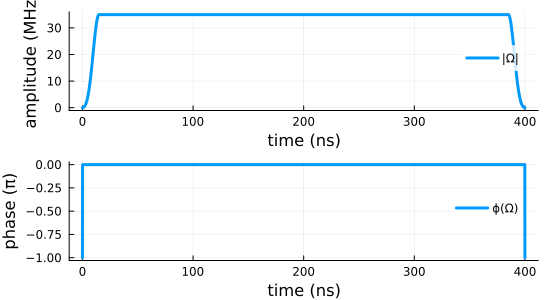

In [6]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)
using QuantumControl.Controls: discretize

function plot_complex_pulse(tlist, Ω; time_unit=:ns, ampl_unit=:MHz, kwargs...)

    Ω = discretize(Ω, tlist)  # make sure Ω is defined on *points* of `tlist`

    ax1 = plot(
        tlist ./ eval(time_unit),
        abs.(Ω) ./ eval(ampl_unit);
        label="|Ω|",
        xlabel="time ($time_unit)",
        ylabel="amplitude ($ampl_unit)",
        kwargs...
    )

    ax2 = plot(
        tlist ./ eval(time_unit),
        angle.(Ω) ./ π;
        label="ϕ(Ω)",
        xlabel="time ($time_unit)",
        ylabel="phase (π)"
    )

    plot(ax1, ax2, layout=(2, 1))

end

plot_complex_pulse(tlist, Array(Ωre_guess) .+ 𝕚 .* Array(Ωim_guess))

We now instantiate the Hamiltonian with these control fields:

In [7]:
H = transmon_hamiltonian(Ωre=Ωre_guess, Ωim=Ωim_guess)

Generator{SparseArrays.SparseMatrixCSC{ComplexF64, Int64}, QuantumPropagators.Amplitudes.ShapedPulseAmplitude}(<3 ops>, <2 amplitudes>)

## Logical basis for two-qubit gates

For simplicity, we will be define the qubits in the *bare* basis, i.e.
ignoring the static coupling $J$.

In [8]:
function ket(i::Int64; N=N)
    Ψ = zeros(ComplexF64, N)
    Ψ[i+1] = 1
    return Ψ
end

function ket(indices::Int64...; N=N)
    Ψ = ket(indices[1]; N=N)
    for i in indices[2:end]
        Ψ = Ψ ⊗ ket(i; N=N)
    end
    return Ψ
end

function ket(label::AbstractString; N=N)
    indices = [parse(Int64, digit) for digit in label]
    return ket(indices...; N=N)
end;

In [9]:
basis = [ket("00"), ket("01"), ket("10"), ket("11")];

## Optimizing for a specific quantum gate

Our target gate is $\Op{O} = \sqrt{\text{iSWAP}}$:

In [10]:
SQRTISWAP = [
    1  0    0   0
    0 1/√2 𝕚/√2 0
    0 𝕚/√2 1/√2 0
    0  0    0   1
];

For each basis state, we get a target state that results from applying the
gate to the basis state (you can convince yourself that this equivalent
multiplying the transpose of the above gate matrix to the vector of basis
states):

In [11]:
basis_tgt = transpose(SQRTISWAP) * basis;

The mapping from each initial (basis) state to the corresponding target state
constitutes an "objective" for the optimization:

In [12]:
objectives = [
    Objective(initial_state=Ψ, target_state=Ψtgt, generator=H) for
    (Ψ, Ψtgt) ∈ zip(basis, basis_tgt)
];

We can analyze how all of the basis states evolve under the guess controls in
one go:

In [13]:
guess_states = propagate_objectives(objectives, tlist; use_threads=true);

The gate implemented by the guess controls is

In [14]:
U_guess = [basis[i] ⋅ guess_states[j] for i = 1:4, j = 1:4];

We will optimize these objectives with a square-modulus functional

In [15]:
using QuantumControl.Functionals: J_T_sm

The initial value of the functional is

In [16]:
J_T_sm(guess_states, objectives)

0.9156372510991495

which is the gate error

In [17]:
1 - (abs(tr(U_guess' * SQRTISWAP)) / 4)^2

0.9156372510991496

Now, we define the full optimization problems on top of the list of
objectives, and with the optimization functional:

In [18]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    iter_stop=100,
    J_T=J_T_sm,
    check_convergence=res -> begin
        (
            (res.J_T > res.J_T_prev) &&
            (res.converged = true) &&
            (res.message = "Loss of monotonic convergence")
        )
        ((res.J_T <= 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end,
    use_threads=true,
);

In [19]:
opt_result = @optimize_or_load(datadir("GATE_OCT.jld2"), problem; method=:GRAPE, force=true);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   9.16e-01   1.41e-01        n/a    1(0)    11.1
     1   8.94e-01   2.36e-01  -2.19e-02    1(0)     0.8
     2   8.85e-01   6.54e-01  -8.30e-03    1(0)     0.6
     3   8.52e-01   4.18e-01  -3.35e-02    1(0)     0.6
     4   7.97e-01   9.12e-01  -5.47e-02    1(0)     0.7
     5   5.81e-01   1.15e+00  -2.16e-01    2(0)     1.5
     6   4.49e-01   6.34e-01  -1.32e-01    2(0)     1.3
     7   4.27e-01   4.43e-01  -2.16e-02    2(0)     1.2
     8   3.97e-01   4.53e-01  -3.06e-02    1(0)     0.6
     9   2.82e-01   1.28e+00  -1.15e-01    1(0)     0.8
    10   1.96e-01   6.70e-01  -8.51e-02    1(0)     0.7
    11   1.83e-01   8.17e-01  -1.31e-02    1(0)     0.8
    12   1.61e-01   3.98e-01  -2.23e-02    1(0)     0.6
    13   1.53e-01   2.25e-01  -7.98e-03    1(0)     0.6
    14   1.42e-01   2.21e-01  -1.08e-02    1(0)     0.6
    15   1.05e-01   5.66e-01  -3.69e-02    1(0)     0.6
    16   8.56e-02   3.88e-01  -1.98e-02    1(0) 

In [20]:
opt_result

GRAPE Optimization Result
-------------------------
- Started at 2022-12-02T02:11:08.741
- Number of objectives: 4
- Number of iterations: 38
- Number of pure func evals: 0
- Number of func/grad evals: 43
- Value of functional: 6.92999e-04
- Reason for termination: J_T < 10⁻³
- Ended at 2022-12-02T02:11:46.635 (37 seconds, 894 milliseconds)


We extract the optimized control field from the optimization result and plot
the resulting amplitude.

The `optimized_controls` field of the `opt_results` contains the optimized
controls $ϵ(t)$.

In [21]:
ϵ_opt = opt_result.optimized_controls[1] + 𝕚 * opt_result.optimized_controls[2];

These must still be multiplied by the static shape $S(t)$ that we set up
for the guess amplitudes

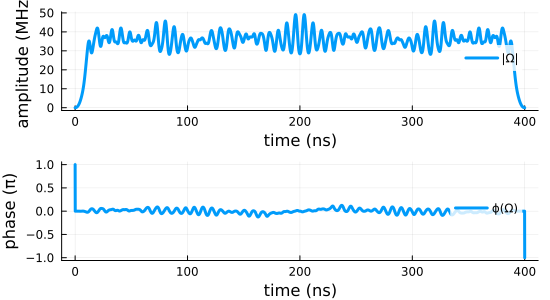

In [22]:
Ω_opt = ϵ_opt .* discretize(Ωre_guess.shape, tlist)

plot_complex_pulse(tlist, Ω_opt)

We then propagate the optimized control field to analyze the resulting
quantum gate:

In [23]:
using QuantumControl.Controls: get_controls, substitute

opt_states = propagate_objectives(
    substitute(
        objectives,
        IdDict(zip(get_controls(objectives), opt_result.optimized_controls))
    ),
    tlist;
    use_threads=true
);

The resulting gate is

In [24]:
U_opt = [basis[i] ⋅ opt_states[j] for i = 1:4, j = 1:4];

and we can verify the resulting fidelity

In [25]:
(abs(tr(U_opt' * SQRTISWAP)) / 4)^2

0.9993070008845545

## Optimizing for a general perfect entangler

We define the optimization with one objective for each of the four basis
states:

In [26]:
objectives = [Objective(; initial_state=Ψ, generator=H) for Ψ ∈ basis];

Note that we omit the `target_state` here. This is because we will be
optimizing for an arbitrary perfect entangler, not for a specific quantum
gate. Thus, there is no a-priori known target state to which the initial
state must evolve.

The optimization is steered by the perfect entanglers distance measure
$D_{PE}$, that is, the geometric distance of the quantum gate obtained from
propagating the four basis states to the polyhedron of perfect entanglers in
the Weyl chamber. Since the logical subspace defining the qubit is embedded
in the larger Hilbert space of the transmon, there may be loss of population
from the logical subspace. To counter this possibility in the optimization,
we add a unitarity measure  to $D_{PE}$. The two terms are added with equal
weight.

In [27]:
using QuantumControl.WeylChamber: D_PE, gate_concurrence, unitarity
using QuantumControl.Functionals: gate_functional

J_T_PE = gate_functional(D_PE; unitarity_weight=0.5);

The `gate_functional` routines used above converts the function `D_PE` that
receives the gate $Û$ as a 4×4 matrix into a functional of the correct from
for the `QuantumControl.optimize` routine, which is a function of the
propagated states.

We can check that for the guess pulse, we are not implementing a perfect
entangler

In [28]:
gate_concurrence(U_guess)

0.777311619851406

We find that the guess pulse produces a gate in the `W0*` region of the Weyl
chamber:

In [29]:
using QuantumControl.WeylChamber: weyl_chamber_region
weyl_chamber_region(U_guess)

"W0*"

That is, the region of the Weyl chamber containing controlled-phase gates with
a phase $> π$ (Weyl chamber coordinates $c₁ > π/2$, $c₂ < π/4$).

This in fact allows use to use the perfect entangler functional without
modification: if the guess pulse were in the "W1" region of the Weyl chamber,
(close to SWAP), we would have to flip its sign, or we would optimize towards
the local equivalence class of the SWAP gate instead of towards the perfect
of perfect entanglers. In principle, we could use a modified functional that
takes the absolute square of the `D_PE` term, by using

```
J_T_PE = gate_functional(D_PE; unitarity_weight=0.5, absolute_square=true)
```

This would specifically optimize for the *surface* of the perfect
entanglers functional.

The guess pulse loses about 10% of population from the logical subspace:

In [30]:
1 - unitarity(U_guess)

0.09071664593821849

We can also evaluate the geometric distance to the polyhedron of perfect
entanglers in the Weyl chamber:

In [31]:
D_PE(U_guess)

0.7787454222392172

Together with the unitarity measure, this is the initial value of the
optimization functional:

In [32]:
0.5 * D_PE(U_guess) + 0.5 * (1 - unitarity(U_guess))

0.4347310340887178

In [33]:
J_T_PE(guess_states, objectives)

0.4347310340887178

For the standard functional `J_T_sm` used in the previous section, our GRAPE
was able to automatically use an analytic implementation of the gradient. For
the perfect-entanglers functional, an analytic gradient exist, but is very
cumbersome to implement. Instead, we make use of semi-automatic
differentiation. As shown in Goerz et al., arXiv:2205.15044, by evaluating
the gradient via a chain rule in the propagated states, the dependency of the
gradient on the final time functional is pushed into the boundary condition
for the backward propagation, $|χ_k⟩ = -∂J_T/∂⟨ϕ_k|$. We can further
exploit that `J_T` is an explicit function of the two-qubit gate in the
computational basis and use a chain rule with respect to the elements of the
two-qubit gate $U_{kk'}$. The remaining derivatives $∂J_T/∂U_{kk'}$ are
then obtained via automatic differentiation. This is set up via the
`make_gate_chi` function,

In [34]:
using QuantumControl.Functionals: make_gate_chi
chi_pe = make_gate_chi(D_PE, objectives; unitarity_weight=0.5);

where the resulting `chi_pe` must be passed to the optimization.

Now, we formulate the full control problem

In [35]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    iter_stop=100,
    J_T=J_T_PE,
    chi=chi_pe,
    check_convergence=res -> begin
        (
            (res.J_T > res.J_T_prev) &&
            (res.converged = true) &&
            (res.message = "Loss of monotonic convergence")
        )
        (
            (res.J_T <= 1e-3) &&
            (res.converged = true) &&
            (res.message = "Found a perfect entangler")
        )
    end,
    use_threads=true,
);

With this, we can easily find a solution to the control problem:

In [36]:
opt_result = @optimize_or_load(datadir("PE_OCT.jld2"), problem; method=:GRAPE, force=true);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   4.35e-01   3.92e-01        n/a    1(0)    35.1
     1   3.35e-01   7.52e-01  -9.94e-02    1(0)     0.8
     2   1.69e-01   3.19e-01  -1.67e-01    1(0)     0.7
     3   1.43e-01   2.09e-01  -2.59e-02    1(0)     0.7
     4   1.00e-01   2.24e-01  -4.24e-02    1(0)     0.6
     5   5.72e-02   2.60e-01  -4.33e-02    2(0)     1.1
     6   4.96e-02   5.41e-01  -7.51e-03    1(0)     0.6
     7   7.82e-03   1.82e-01  -4.18e-02    1(0)     0.7
     8  -4.26e-03   1.13e-01  -1.21e-02    1(0)     0.5


In [37]:
opt_result

GRAPE Optimization Result
-------------------------
- Started at 2022-12-02T02:11:59.768
- Number of objectives: 4
- Number of iterations: 8
- Number of pure func evals: 0
- Number of func/grad evals: 10
- Value of functional: -4.25769e-03
- Reason for termination: Found a perfect entangler
- Ended at 2022-12-02T02:12:40.669 (40 seconds, 901 milliseconds)


We extract the optimized control field from the optimization result and plot
it

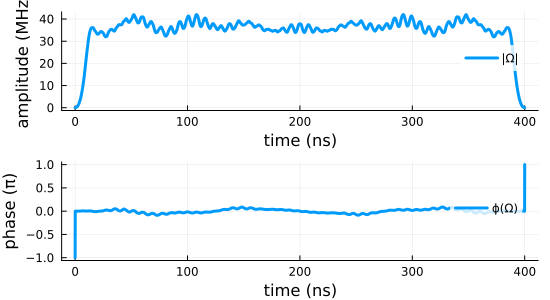

In [38]:
ϵ_opt = opt_result.optimized_controls[1] + 𝕚 * opt_result.optimized_controls[2]
Ω_opt = ϵ_opt .* discretize(Ωre_guess.shape, tlist)

plot_complex_pulse(tlist, Ω_opt)

We then propagate the optimized control field to analyze the resulting
quantum gate:

In [39]:
opt_states = propagate_objectives(
    substitute(
        objectives,
        IdDict(zip(get_controls(objectives), opt_result.optimized_controls))
    ),
    tlist;
    use_threads=true
);

U_opt = [basis[i] ⋅ opt_states[j] for i = 1:4, j = 1:4];

We find that we have achieved a perfect entangler:

In [40]:
gate_concurrence(U_opt)

1.0

Moreover, we have reduced the population loss to less than 4%

In [41]:
1 - unitarity(U_opt)

0.035261694552444545

## Direct maximization of the gate concurrence

In the previous optimizations, we have optimized for a perfect entangler
indirectly via a geometric function in the Weyl chamber. The entire reason
that perfect entangler functional was formulated is because calculating the
gate concurrence directly involves the eigenvalues of the unitary, see
Kraus, Cirac, Phys. Rev. A 63, 062309 (2001) and
Childs et al., PRA 68, 052311 (2003), which are inherently non-analytic.

However, since we are able to obtain gradient from automatic differentiation,
this is no longer an insurmountable obstacle

We can define a functional for a given gate `U` that combines the gate
concurrence and (as above) a unitarity measure to penalize loss of population
from the logical subspace:

In [42]:
J_T_C = U -> 0.5 * (1 - gate_concurrence(U)) + 0.5 * (1 - unitarity(U));

In the optimization, we will convert this functional to one that takes the
propagated states as arguments (via the `gate_functional` routine).
Also, as before, we have to create a matching routine for the boundary condition
$|χ_k⟩ = -\frac{∂}{∂⟨ϕ_k|} J_T$ of the backward-propagation via the
`make_gate_chi` routine.

Running the optimization, we again are able to find a perfect entangler.

In [43]:
opt_result_direct = @optimize_or_load(
    datadir("PE_OCT_direct.jld2"),
    problem;
    method=:GRAPE,
    J_T=gate_functional(J_T_C),
    chi=make_gate_chi(J_T_C, objectives),
    force=true
);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   1.57e-01   1.42e-01        n/a    1(0)    12.4
     1   1.46e-01   3.18e-01  -1.05e-02    1(0)     0.7
     2   1.30e-01   2.86e-01  -1.61e-02    1(0)     0.8
     3   8.10e-02   2.10e-01  -4.91e-02    2(0)     1.3
     4   7.66e-02   3.79e-01  -4.41e-03    1(0)     0.6
     5   4.89e-02   1.87e-01  -2.77e-02    1(0)     0.6
     6   2.64e-02   2.11e-01  -2.25e-02    1(0)     0.6
     7   7.54e-03   1.09e-01  -1.89e-02    1(0)     0.7
     8   5.86e-03   1.98e-01  -1.68e-03    1(0)     1.0
     9   3.00e-03   4.01e-02  -2.87e-03    1(0)     0.8
    10   2.71e-03   2.72e-02  -2.88e-04    1(0)     0.7
    11   2.21e-03   2.82e-02  -5.01e-04    1(0)     0.8
    12   1.42e-03   2.46e-02  -7.84e-04    1(0)     0.7
    13   3.24e-04   2.83e-02  -1.10e-03    1(0)     0.8


In [44]:
opt_result_direct

GRAPE Optimization Result
-------------------------
- Started at 2022-12-02T02:12:41.569
- Number of objectives: 4
- Number of iterations: 13
- Number of pure func evals: 0
- Number of func/grad evals: 15
- Value of functional: 3.24322e-04
- Reason for termination: Found a perfect entangler
- Ended at 2022-12-02T02:13:04.118 (22 seconds, 549 milliseconds)


In [45]:
opt_states_direct = propagate_objectives(
    substitute(
        objectives,
        IdDict(zip(get_controls(objectives), opt_result_direct.optimized_controls))
    ),
    tlist;
    use_threads=true
);

U_opt_direct = [basis[i] ⋅ opt_states_direct[j] for i = 1:4, j = 1:4];

In [46]:
gate_concurrence(U_opt_direct)

1.0

In [47]:
1 - unitarity(U_opt_direct)

0.0006486436935997375

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*